In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from textblob import TextBlob
import spacy
import spacy.util
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
trans = preprocessing.MinMaxScaler()
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nlp = spacy.load("/kaggle/input/en-core-web-lg/en_core_web_lg/en_core_web_lg-3.8.0")

In [3]:
download_dir="/root/nltk_data"

In [4]:
# IN KAGGLE:
train = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
test = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")
display(train.head(2))

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5


## Text Feature Engineering

In [5]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [6]:
var = 'n_capital'
train[var]=train['full_text'].apply(count_capital_words)
test[var]=test['full_text'].apply(count_capital_words)

### Punctuation

In [7]:
def count_punctuations(text):
    punctuations="'!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'"
    count=0
    for i in punctuations:
        count+=text.count(i)
    return count

In [8]:
var = 'n_punct'
train[var]=train['full_text'].apply(count_punctuations)
test[var]=test['full_text'].apply(count_punctuations)

In [9]:
def text_cleaner(text):
    text = text.strip()
    text = re.sub(r'\n', ' ', text)
    text = text.lower()
    return text

In [10]:
train['full_text']=train['full_text'].apply(text_cleaner)
test['full_text']=test['full_text'].apply(text_cleaner)

### Number of Unique Words

In [11]:
def n_unique_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    unique_words = np.unique(words)
    return len(unique_words)

In [12]:
var = 'n_unique'
train[var]=train['full_text'].apply(n_unique_words)
test[var]=test['full_text'].apply(n_unique_words)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

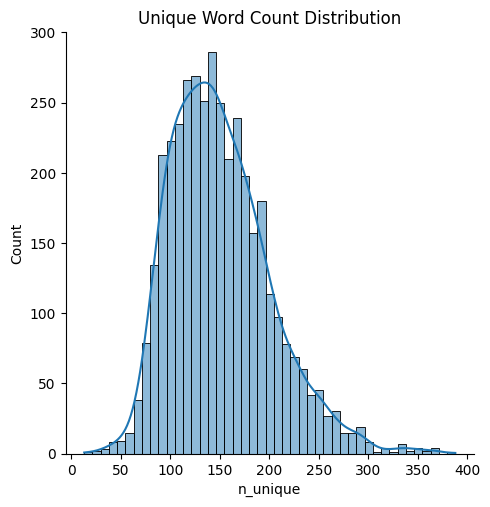

In [13]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Unique Word Count Distribution')
plt.show()

### Number of Unique Words (exclude stop words)

In [14]:
nltk.download('stopwords', download_dir=download_dir)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [15]:
nltk.data.path.append(download_dir)

In [16]:
def n_unique_words_no_stop(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    #remove stop words
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [17]:
var = 'n_unique_n_stop'
train[var]=train['full_text'].apply(n_unique_words_no_stop)
test[var]=test['full_text'].apply(n_unique_words_no_stop)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

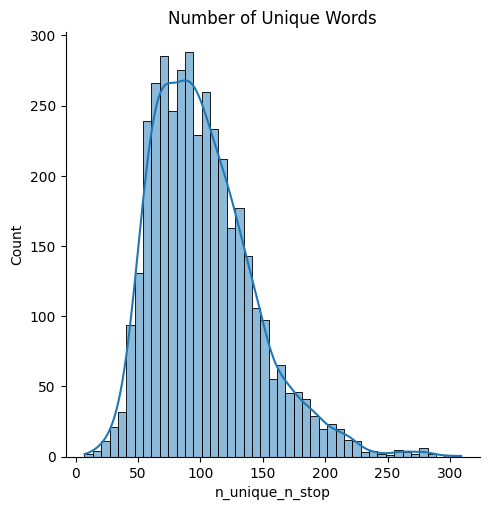

In [18]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Number of Unique Words')
plt.show()

### Number of Non-words

In [19]:
def n_non_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = ['a', 'i', ' ']
    #remove stop words
    words = [word for word in words if len(word) == 1]
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [20]:
var = 'n_n_word'
train[var]=train['full_text'].apply(n_non_words)
test[var]=test['full_text'].apply(n_non_words)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

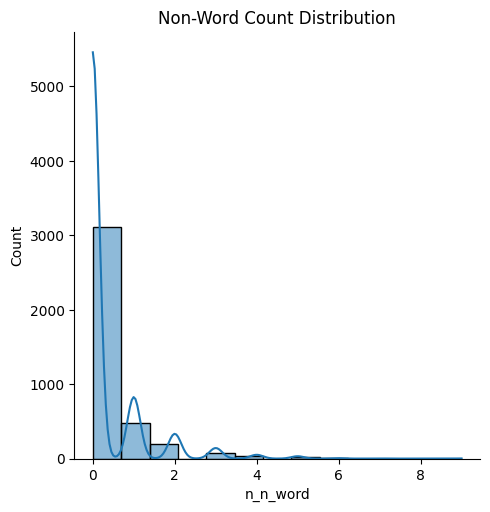

In [21]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Non-Word Count Distribution')
plt.show()

### Number of Noun Phrases

In [22]:
nltk.download('brown', download_dir=download_dir)
nltk.download('punkt_tab', download_dir=download_dir)

[nltk_data] Error loading brown: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [23]:
def count_noun_phrases(text):
    blob = TextBlob(text)
    return len(blob.noun_phrases)

In [24]:
var = 'noun_phrase_count'
train[var]=train['full_text'].apply(count_noun_phrases)
test[var]=test['full_text'].apply(count_noun_phrases)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

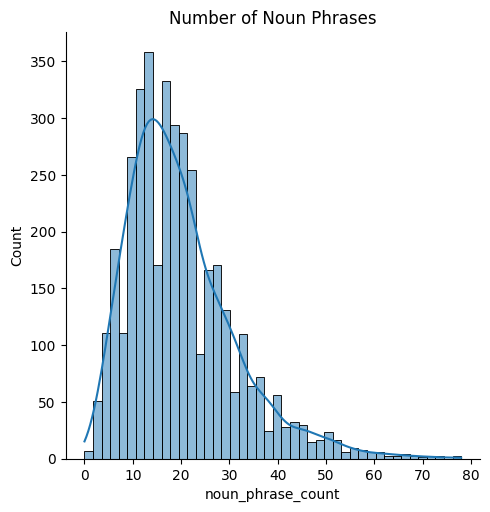

In [25]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Number of Noun Phrases')
plt.show()

### Parts of Speech Tagging

In [26]:
def pos(text):
    doc = nlp(text)
    result = dict(Counter([t.pos_ for t in doc]))
    missing = set(var) - set(result.keys())
    for miss in missing:
        result[miss] = np.nan
    return pd.Series(result)

In [27]:
var = ['PRON', 'VERB',	'SCONJ', 'NOUN', 'AUX', 'ADP', 'PUNCT', 'PART',	'CCONJ', 'ADV', 'DET', 'ADJ', 'SPACE', 'PROPN', 'NUM', 'INTJ', 'SYM', 'X']
train[var]=train['full_text'].apply(pos)

In [28]:
test[var]=test['full_text'].apply(pos)

### Distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

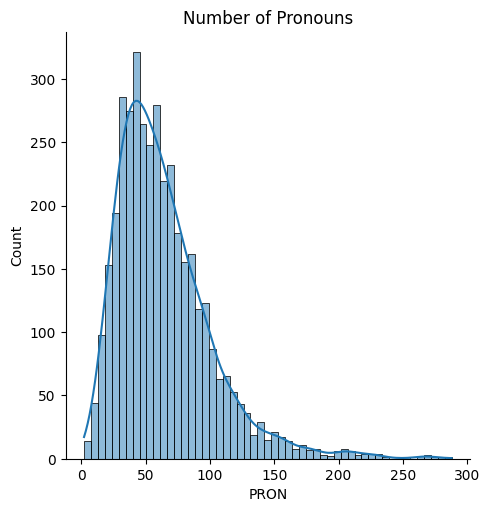

In [29]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='PRON',kde="True")
plt.title('Number of Pronouns')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

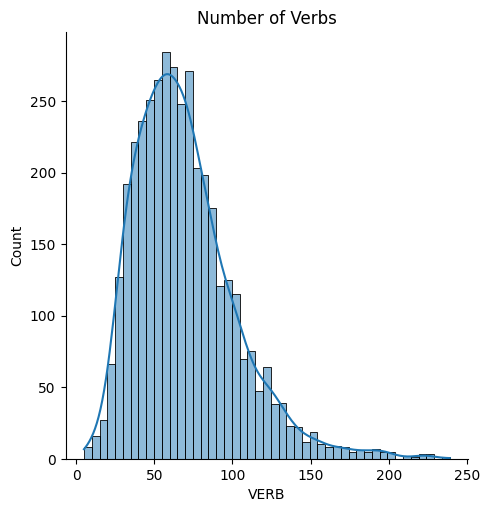

In [30]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='VERB',kde="True")
plt.title('Number of Verbs')
plt.show()

In [31]:
train = train.fillna(0.0)
test = test.fillna(0.0)

### Sentiment Polarity

In [32]:
def essay_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [33]:
var = 'polarity'
train[var]=train['full_text'].apply(essay_polarity)
test[var]=test['full_text'].apply(essay_polarity)

### Essay Subjectivity

In [34]:
def essay_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [35]:
var = 'subjectivity'
train[var]=train['full_text'].apply(essay_subjectivity)
test[var]=test['full_text'].apply(essay_subjectivity)

### Grammar

TextBlob(text).correct():

"I havv a dreem" -> "I have a dream"

In [36]:
def spell_similarity(text): 
    b = nlp(TextBlob(text).correct().string)
    return nlp(text).similarity(b)

In [37]:
tqdm.pandas()

train['spell_score'] = train['full_text'].progress_apply(spell_similarity)

  0%|          | 0/3911 [00:00<?, ?it/s]

In [38]:
test['spell_score'] = test['full_text'].progress_apply(spell_similarity)

  0%|          | 0/3 [00:00<?, ?it/s]

### Sentence Statistics

In [39]:
def sentence_av_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.mean(list(sent_len))

train['av_sent_len']=train['full_text'].apply(sentence_av_len_calc)
test['av_sent_len']=test['full_text'].apply(sentence_av_len_calc)

In [40]:
def sentence_max_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.max(list(sent_len))

train['max_sent_len']=train['full_text'].apply(sentence_max_len_calc)
test['max_sent_len']=test['full_text'].apply(sentence_max_len_calc)

In [41]:
def sentence_min_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.min(list(sent_len))

train['min_sent_len']=train['full_text'].apply(sentence_min_len_calc)
test['min_sent_len']=test['full_text'].apply(sentence_min_len_calc)

In [42]:
def sentence_median_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.median(list(sent_len))

train['med_sent_len']=train['full_text'].apply(sentence_median_len_calc)
test['med_sent_len']=test['full_text'].apply(sentence_median_len_calc)

In [43]:
def sentence_std_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.std(list(sent_len))

train['std_sent_len']=train['full_text'].apply(sentence_std_len_calc)
test['std_sent_len']=test['full_text'].apply(sentence_std_len_calc)

### Number of sentences

In [44]:
def sentence_count(text):
    sentences = text.split(".")
    return len(sentences)

In [45]:
train['num_sent']=train['full_text'].apply(sentence_count)
test['num_sent']=test['full_text'].apply(sentence_count)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x2000 with 0 Axes>

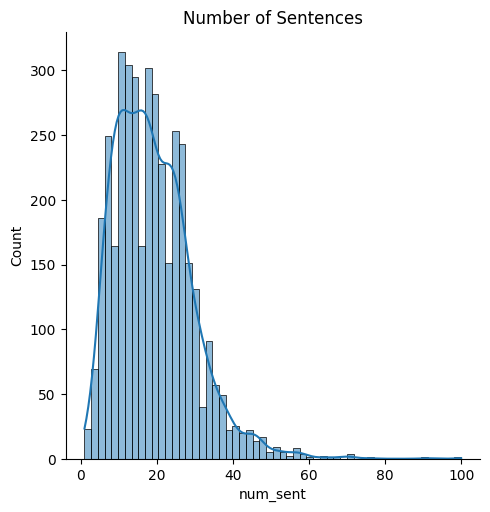

In [46]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='num_sent',kde="True")
plt.title('Number of Sentences')
plt.show()

### Sentiment Scores

In [47]:
nltk.download('vader_lexicon', download_dir=download_dir)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

sentiment scores: –4 (very negativ) and +4 (very positiv).

In [48]:
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['full_text'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu
train['compound'],train['negative'],train['positive'],train['neutral']=generate_sentiment_scores(train)
test['compound'],test['negative'],test['positive'],test['neutral']=generate_sentiment_scores(test)

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
display(train[['full_text', 'compound', 'negative', 'positive', 'neutral']].head(5))

,full_text,compound,negative,positive,neutral
0,i think that students would benefit from learn...,0.9363,0.051,0.099,0.850
1,when a problem is a change you have to let it ...,-0.9194,0.111,0.091,0.798
2,"dear, principal if u change the school policy...",0.9271,0.054,0.110,0.837
3,the best time in life is when you become yours...,0.9995,0.052,0.245,0.704
4,small act of kindness can impact in other peop...,0.9868,0.000,0.164,0.836


### Character Length

In [50]:
train['char_len']=train['full_text'].apply(lambda x:len(x.split()))
test['char_len']=test['full_text'].apply(lambda x:len(x.split()))

In [51]:
processed_train = pd.DataFrame()
processed_test = pd.DataFrame()
processed_train["tokens"] = train["full_text"].apply(lambda s: word_tokenize(s))
processed_test["tokens"] = test["full_text"].apply(lambda s: word_tokenize(s))
processed_train["sentences"] = train["full_text"].apply(lambda s: nltk.sent_tokenize(s))
processed_test["sentences"] = test["full_text"].apply(lambda s: nltk.sent_tokenize(s))

### Word Diversity

How many different words contains the text?

In [52]:
def lexical_diversity(tokens):
    return len(set(tokens)) / max(len(tokens), 1)

train["lex_diversity"] = processed_train["tokens"].apply(lexical_diversity)
test["lex_diversity"] = processed_test["tokens"].apply(lexical_diversity)

## TF-IDF

TF: term-frequency

IDF: inversed-document-frequency

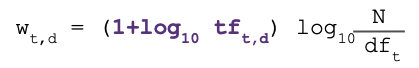

In [53]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10_000,
    min_df=5
)
X_tfidf_train = tfidf.fit_transform(train['full_text'])
X_tfidf_test = tfidf.transform(test['full_text'])

In [54]:
tfidf_means = np.asarray(X_tfidf_train.mean(axis=0)).flatten()
tfidf_features = tfidf.get_feature_names_out()

In [55]:

# Convert to DataFrame
tfidf_df_train = pd.DataFrame(X_tfidf_train.toarray(), columns=tfidf_features, index=train.index)
tfidf_df_test = pd.DataFrame(X_tfidf_test.toarray(), columns=tfidf_features, index=test.index)


In [56]:

# Concatenate to original DataFrames
train = pd.concat([train.reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)

In [57]:


# Top 20 Features
top_n = 20
top_indices = tfidf_means.argsort()[::-1][:top_n]
top_features = [tfidf_features[i] for i in top_indices]
top_values = tfidf_means[top_indices]

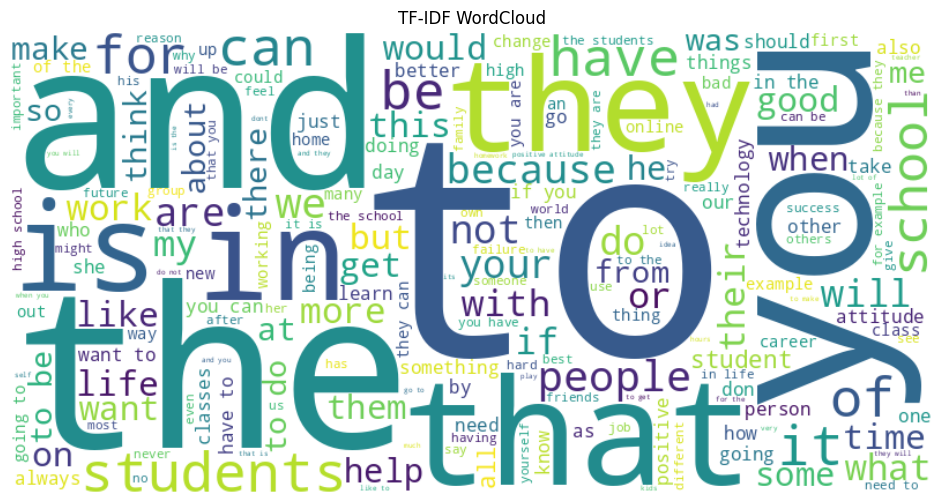

In [58]:
# Dictionary: {feature_name: mean_tfidf_value}
tfidf_dict = {tfidf_features[i]: tfidf_means[i] for i in range(len(tfidf_features))}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("TF-IDF WordCloud")
plt.show()

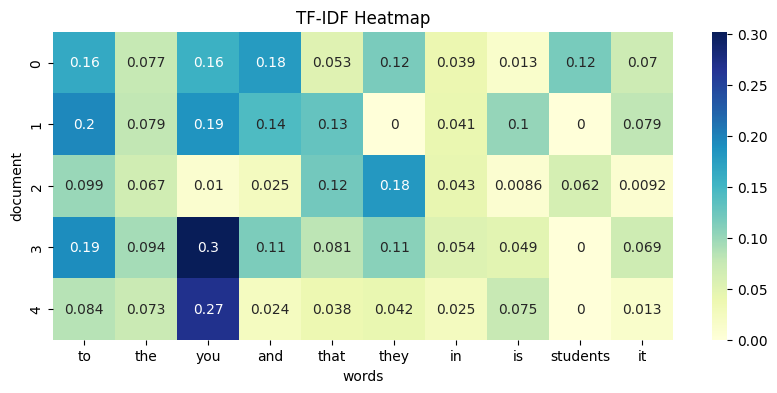

In [59]:
n_docs = 5
top_words = top_features[:10]  # Top 10 words

top_word_indices = [np.where(tfidf_features == word)[0][0] for word in top_words]

# extract TF-IDF-values 
subset = X_tfidf_train[:n_docs, top_word_indices].toarray()

df_heat = pd.DataFrame(subset, columns=top_words)
plt.figure(figsize=(10, 4))
sns.heatmap(df_heat, annot=True, cmap="YlGnBu")
plt.title("TF-IDF Heatmap")
plt.xlabel("words")
plt.ylabel("document")
plt.show()

### Extract the labels

In [60]:
y_train=train[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']]

In [61]:
train.to_csv('/kaggle/working/train_vars.csv', index=False)
y_train.to_csv('/kaggle/working/train_y_vars.csv', index=False)
test.to_csv('/kaggle/working/test_vars.csv', index=False)

In [62]:
display(train.head(5))

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_capital,n_punct,...,yourself if,yourself in,yourself is,yourself or,yourself that,yourself to,yourself you,youtube,zone,zoo
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1,25,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2,27,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00299B378633,"dear, principal if u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,9,56,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,9,166,...,0.0,0.093427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0,3,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'n_capital', 'n_punct',
       ...
       'yourself if', 'yourself in', 'yourself is', 'yourself or',
       'yourself that', 'yourself to', 'yourself you', 'youtube', 'zone',
       'zoo'],
      dtype='object', length=10047)

In [64]:
df_train = pd.read_csv("/kaggle/working/train_vars.csv")
df_test = pd.read_csv("/kaggle/working/test_vars.csv")
print(df_train)

           text_id                                          full_text  \
0     0016926B079C  i think that students would benefit from learn...   
1     0022683E9EA5  when a problem is a change you have to let it ...   
2     00299B378633  dear, principal  if u change the school policy...   
3     003885A45F42  the best time in life is when you become yours...   
4     0049B1DF5CCC  small act of kindness can impact in other peop...   
...            ...                                                ...   
3906  FFD29828A873  i believe using cellphones in class for educat...   
3907  FFD9A83B0849  working alone, students do not have to argue w...   
3908  FFDC4011AC9C  "a problem is a chance for you to do your best...   
3909  FFE16D704B16  many people disagree with albert schweitzer's ...   
3910  FFED00D6E0BD  do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
0          3.5     3.5         3.0          3.0   

In [65]:
label_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [66]:
feature_cols = df_train.columns.difference(['text_id', 'full_text'] + label_cols).tolist()

In [67]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [68]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        colwise_mse = self.mse(preds, targets).mean(dim=0)
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)
        return colwise_rmse.mean()

In [69]:
X = df_train[feature_cols]
y_all = df_train[label_cols]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_all, test_size=0.2, random_state=42
)

# train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# convert in torch.Tensor 
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) 

# calculate MCRMSE 
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit MCRMSE: {loss_value.item():.4f}")

Evaluation mit MCRMSE: 0.5510


In [70]:
X_submission = df_test[feature_cols]

submission_preds = model.predict(X_submission)

submission_df = pd.DataFrame(submission_preds, columns=label_cols)
submission_df["text_id"] = df_test["text_id"]  # text_id hinzufügen
submission_df = submission_df[["text_id"] + label_cols]  # Spalten sortieren

submission_df.to_csv("submission.csv", index=False)